# Convergence issue

In [ ]:
%%capture
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation
import seaborn as sns
sns.set()
plt.rcParams["animation.html"] = "html5"
from pylab import rcParams
rcParams['figure.figsize'] = 13, 7
import numpy as np


x_min, x_max = -1, 1
y_min, y_max = 0, 2
N_iter = 20
x_0 = 1

fig, ax = plt.subplots()
xdata = np.linspace(x_min,x_max)
ydata = xdata**4
plt.plot(xdata, ydata)
plt.xlabel(f'$x$')
plt.ylabel(f'$f(x) = x^4$')
line, = ax.plot([], [], marker='o', linestyle='-', color='r', label='Newton', lw=2)
plt.legend()
# ax.grid()
xdata, ydata = [x_0], [x_0**4]

def data_gen(t=0):
    cnt = 0
    x = x_0
    while cnt < N_iter:
        cnt += 1
        x = 2/3*x
        yield x

def init():
    ax.set_ylim(y_min, y_max)
    ax.set_xlim(x_min, x_max)
    line.set_data(xdata, ydata)
    return line,

def run(data):
    # update the data
    x = data
    y = x**4
    xdata.append(x)
    ydata.append(y)
    line.set_data(xdata, ydata)
    return line,

ani = matplotlib.animation.FuncAnimation(fig, run, data_gen, blit=False, interval=1000,
                              repeat=True, init_func=init)

In [ ]:
ani

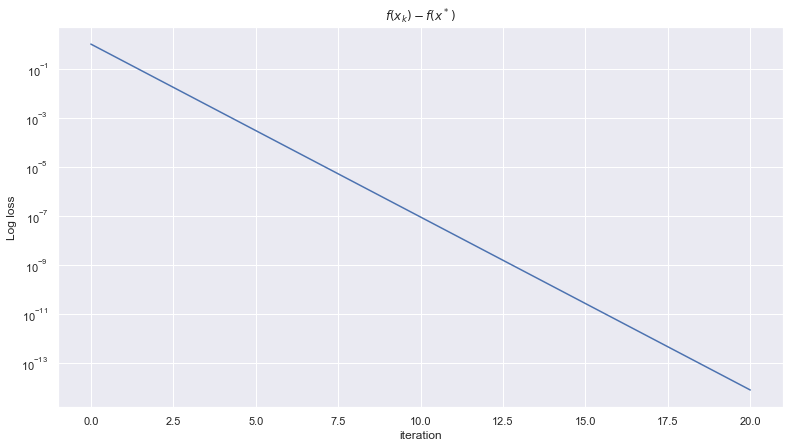

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 13, 7
plt.semilogy(ydata)
plt.title(f'$f(x_k) - f(x^*)$')
plt.xlabel('iteration')
plt.ylabel('Log loss')
plt.show()

# Demonstration of local convergence

In [ ]:
%%capture
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation
plt.rcParams["animation.html"] = "html5"
from pylab import rcParams
rcParams['figure.figsize'] = 13, 7
import numpy as np

x_min, x_max = -3, 3
y_min, y_max = 1, 3
N_iter = 4
x_0 = 0.9



fig, ax = plt.subplots()
xdata = np.linspace(x_min,x_max)
ydata = np.sqrt(1 + xdata**2)
plt.plot(xdata, ydata)
plt.title(r'Newton method convergence for  $y = \sqrt{1 + x^2}$')
plt.xlabel(f'$x$')
plt.ylabel(f'$f(x)$')
line, = ax.plot([], [], marker='o', linestyle='-', color='r', label='Newton', lw=2)
plt.legend()
# ax.grid()
xdata, ydata = [x_0], [np.sqrt(1 + x_0**2)]

def data_gen(t=0):
    cnt = 0
    x = x_0
    while cnt < N_iter:
        cnt += 1
        x = -x**3
        yield x


def init():
    ax.set_ylim(y_min, y_max)
    ax.set_xlim(x_min, x_max)
    line.set_data(xdata, ydata)
    return line,

def run(data):
    # update the data
    x = data
    y = np.sqrt(1 + x**2)
    xdata.append(x)
    ydata.append(y)
    line.set_data(xdata, ydata)
    return line,

ani = matplotlib.animation.FuncAnimation(fig, run, data_gen, blit=False, interval=1000,
                              repeat=True, init_func=init)

In [ ]:
ani

Text(0, 0.5, 'Log loss')

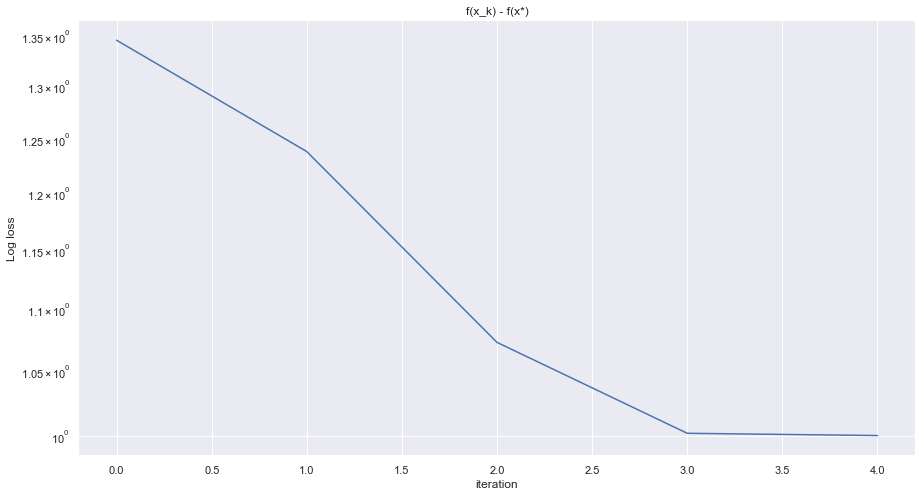

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 8
plt.semilogy(ydata)
plt.title('f(x_k) - f(x*)')
plt.xlabel('iteration')
plt.ylabel('Log loss')

# Newton vs GD

[source](https://github.com/amkatrutsa/MIPT-Opt/tree/master/Spring2020)

In [36]:
import numpy as np

USE_COLAB = True
if USE_COLAB:
    !pip install git+https://github.com/amkatrutsa/liboptpy --quiet
        
import liboptpy.unconstr_solvers as methods
import liboptpy.step_size as ss

n = 1000
m = 200
x0 = np.zeros((n,))
A = np.random.rand(n, m) * 10

import cvxpy as cvx
x = cvx.Variable((n, 1))

obj = cvx.Minimize(cvx.sum(-cvx.log(1 - A.T * x)) - 
                   cvx.sum(cvx.log(1 - cvx.square(x))))
prob = cvx.Problem(obj)
prob.solve(solver="SCS", verbose=True, max_iters=1000)
print("Optimal value =", prob.value)

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 205200
eps = 1.00e-04, alpha = 1.50, max_iters = 1000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 3200, constraints m = 6600
Cones:	soc vars: 3000, soc blks: 1000
	exp vars: 3600, dual exp vars: 0
Setup time: 1.43e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.55e+20  5.07e+22  8.29e-01 -1.18e+23 -1.10e+22  7.05e+23  5.13e-02 
   100| 1.80e-03  6.20e-02  2.63e-03 -1.37e+03 -1.37e+03  2.19e-14  2.41e+00 
   200| 1.19e-03  1.44e-02  7.55e-04 -1.36e+03 -1.37e+03  1.47e-13  4.67e

In [37]:
f = lambda x: -np.sum(np.log(1 - A.T.dot(x))) - np.sum(np.log(1 - x*x))
grad_f = lambda x: np.sum(A.dot(np.diagflat(1 / (1 - A.T.dot(x)))), axis=1) + 2 * x / (1 - np.power(x, 2))
hess_f = lambda x: (A.dot(np.diagflat(1 / (1 - A.T.dot(x))**2))).dot(A.T) + np.diagflat(2 * (1 + x**2) / (1 - x**2)**2)

In [38]:
def Newton(f, gradf, hessf, x0, epsilon, num_iter, line_search, 
                    disp=False, callback=None, **kwargs):
    x = x0.copy()
    iteration = 0
    opt_arg = {"f": f, "grad_f": gradf}
    for key in kwargs:
        opt_arg[key] = kwargs[key]
    while True:
        gradient = gradf(x)
        hess = hessf(x)
        h = np.linalg.solve(hess, -gradient)
        alpha = line_search(x, h, **opt_arg)
        x = x + alpha * h
        if callback is not None:
            callback(x)
        iteration += 1
        if disp:
            print("Current function val =", f(x))
            print("Current gradient norm = ", np.linalg.norm(gradf(x)))
        if np.linalg.norm(gradf(x)) < epsilon:
            break
        if iteration >= num_iter:
            break
    res = {"x": x, "num_iter": iteration, "tol": np.linalg.norm(gradf(x))}
    return res

In [39]:
newton = methods.so.NewtonMethod(f, grad_f, hess_f, ss.Backtracking("Armijo", rho=0.9, beta=0.1, init_alpha=1.))
x_newton = newton.solve(x0, tol=1e-6, max_iter=50, disp=True)

gd = methods.fo.GradientDescent(f, grad_f, ss.Backtracking("Armijo", rho=0.9, beta=0.1, init_alpha=1.))
x_gd = gd.solve(x0, tol=1e-6, max_iter=50, disp=True)

Required tolerance achieved!
Convergence in 14 iterations
Function value = -1368.9378503129074
Norm of gradient = 7.870611074755218e-10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


Required tolerance achieved!
Convergence in 45 iterations
Function value = -1368.9378503129071
Norm of gradient = 9.750175707224204e-07


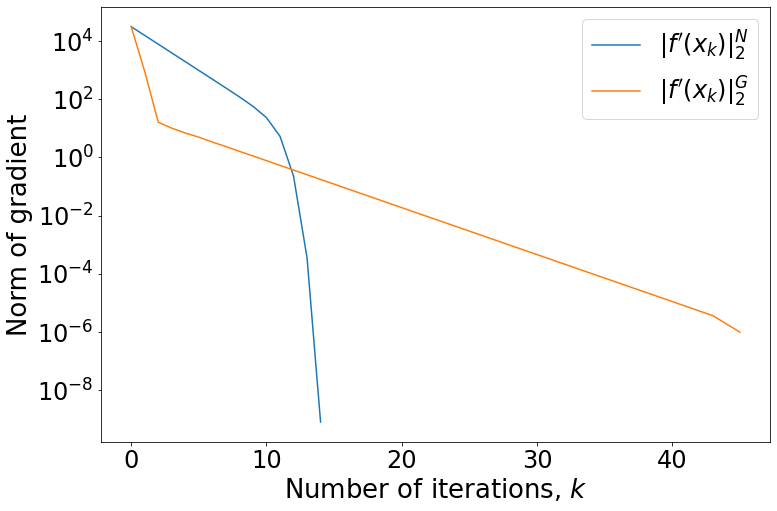

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt

if not USE_COLAB:
    plt.rc("text", usetex=True)
    
plt.figure(figsize=(12, 8))
# Newton
plt.semilogy([np.linalg.norm(grad_f(x)) for x in newton.get_convergence()], label="$\| f'(x_k) \|^{N}_2$")
# Gradient
plt.semilogy([np.linalg.norm(grad_f(x)) for x in gd.get_convergence()], label="$\| f'(x_k) \|^{G}_2$")
plt.xlabel(r"Number of iterations, $k$", fontsize=26)
plt.ylabel(r"Norm of gradient", fontsize=26)
plt.xticks(fontsize = 24)
plt.yticks(fontsize = 24)
plt.legend(loc="best", fontsize=24)

# Newton vs BFGS

In [4]:
!pip install autograd --quiet

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import autograd.numpy as np

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from matplotlib import animation
from IPython.display import HTML

from autograd import elementwise_grad, value_and_grad
from scipy.optimize import minimize
from collections import defaultdict
from itertools import zip_longest
from functools import partial

In [8]:
f  = lambda x, y: (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2

In [9]:
xmin, xmax, xstep = -4.5, 4.5, .2
ymin, ymax, ystep = -4.5, 4.5, .2

x, y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))
z = f(x, y)

In [10]:
# It is known
minima = np.array([3., .5])

In [11]:
f(*minima)

0.0

In [12]:
minima_ = minima.reshape(-1, 1)
minima_

array([[3. ],
       [0.5]])

In [13]:
f(*minima_)

array([0.])

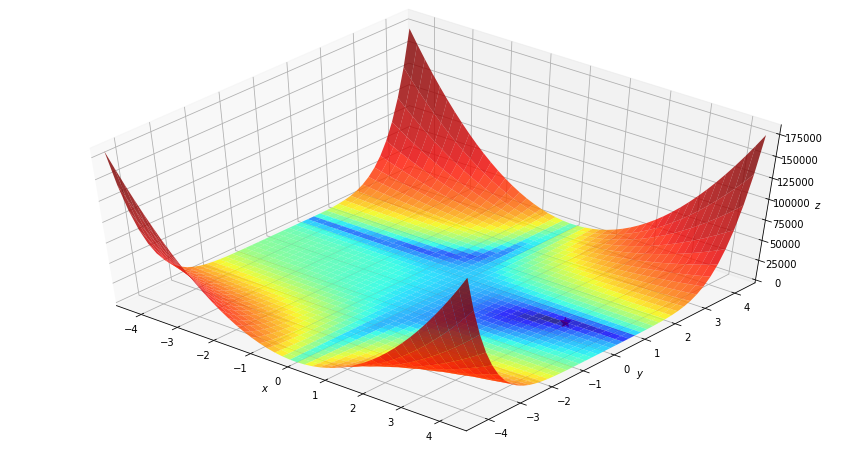

In [14]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 8
ax = plt.axes(projection='3d', elev=50, azim=-50)

ax.plot_surface(x, y, z, norm=LogNorm(), rstride=1, cstride=1, 
                edgecolor='none', alpha=.8, cmap=plt.cm.jet)
ax.plot(*minima_, f(*minima_), 'r*', markersize=10)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

plt.show()

In [15]:
x0 = np.array([1., -3.])

In [16]:
func = value_and_grad(lambda args: f(*args))

In [25]:
def make_minimize_cb(path=[]):
    def minimize_cb(xk):
        # note that we make a deep copy of xk
        path.append(np.copy(xk))

    return minimize_cb

path_ = [x0]

res = minimize(func, x0=x0, method='BFGS',
               jac=True, tol=1e-20, callback=print)

[ 0.26169155 -2.31079711]
[ 0.16181111 -2.41543177]
[ 0.12428932 -2.45726361]
[ 0.12301307 -2.45851716]
[ 0.12316645 -2.45814862]
[ 0.12414512 -2.454845  ]
[ 0.12565349 -2.44854074]
[0.67300726 0.12936225]
[0.66947298 0.11256824]
[0.88761687 0.23248483]
[1.27171157 0.19775867]
[2.1455921  0.03555492]
[2.23404917 0.19351201]
[2.53774447 0.42559427]
[2.60629388 0.38085757]
[2.73569183 0.42143378]
[2.89305622 0.47863871]
[2.95148437 0.48856771]
[2.99180967 0.49846504]
[2.99890556 0.4996404 ]
[3.00014956 0.50005237]
[2.99999946 0.49999984]
[3.  0.5]
[3.  0.5]
[3.  0.5]
[3.  0.5]


In [26]:
dict(res)

{'fun': 0.0, 'hess_inv': array([[3.1178472 , 0.77289684],
        [0.77289684, 0.21326821]]), 'jac': array([0., 0.]), 'message': 'Optimization terminated successfully.', 'nfev': 47, 'nit': 26, 'njev': 47, 'status': 0, 'success': True, 'x': array([3. , 0.5])}

(-4.5, 4.5)

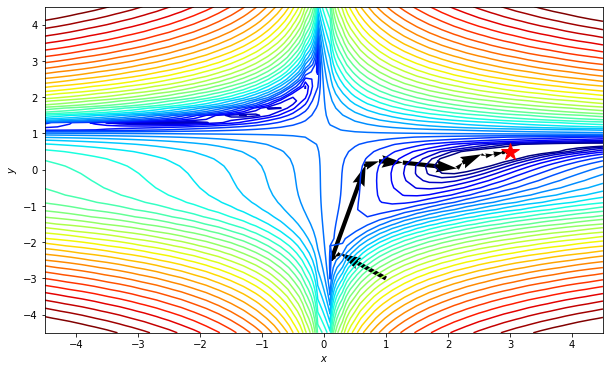

In [27]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
ax.quiver(path[0,:-1], path[1,:-1], path[0,1:]-path[0,:-1], path[1,1:]-path[1,:-1], scale_units='xy', angles='xy', scale=1, color='k')
ax.plot(*minima_, 'r*', markersize=18)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

In [28]:
path_ = [x0]

res = minimize(func, x0=x0, method='Newton-CG',
               jac=True, tol=1e-20, callback=make_minimize_cb(path_))
dict(res)

{'fun': 5.119632425893594e-17,
 'jac': array([5.06560003e-09, 2.64302154e-09]),
 'message': 'Optimization terminated successfully.',
 'nfev': 30,
 'nhev': 0,
 'nit': 21,
 'njev': 116,
 'status': 0,
 'success': True,
 'x': array([3.00000002, 0.5       ])}

In [29]:
path = np.array(path_).T
path.shape

(2, 22)

(-4.5, 4.5)

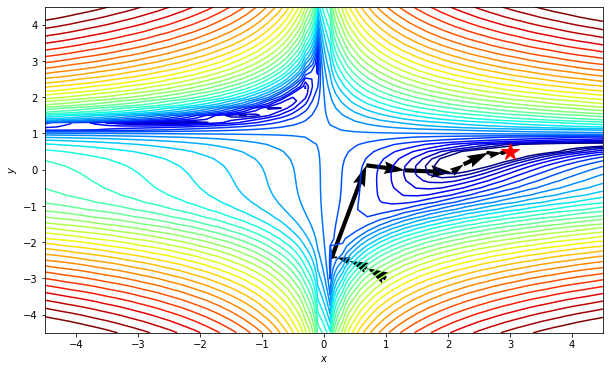

In [30]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
ax.quiver(path[0,:-1], path[1,:-1], path[0,1:]-path[0,:-1], path[1,1:]-path[1,:-1], scale_units='xy', angles='xy', scale=1, color='k')
ax.plot(*minima_, 'r*', markersize=18)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))